# <center> Laboratorio #2: Redes Neuronales </center>

<center> Oscar Juárez - 17315 </center>

<center> Inteligencia Artificial </center>

<center> Fecha: 06/04/2020 </center>

---
## Importar librerías útiles

In [67]:
# Librerías externas
import numpy as np
import pandas as pd
import pickle
import random
from functools import reduce
from scipy import optimize as op
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

# Librerías locales
from fns_redes_neuronales import *

## Extraer contenido del .zip

Este paso se realiza dado que Github no permite subir archivos de más de 100MB, por lo que hay que comprimirlo al subirlo a la plataforma

In [2]:
with zipfile.ZipFile("./data/fashionmnist.zip", "r") as ref:
    ref.extractall("./data")

# 1. Lectura de datasets y definición de datos a utilizar

In [3]:
trainSet = pd.read_csv('data/fashion-mnist_train.csv')
testSet = pd.read_csv('data/fashion-mnist_test.csv')

In [4]:
NROWS = len(trainSet)
TRAIN_ROWS = int(NROWS * 0.6)
NCV = int(NROWS * 0.2)
random.seed(1234)

In [5]:
# Desordenamos nuestros datos
data = trainSet.iloc[:, :].values
# random.shuffle(data)
data = pd.DataFrame(data)

# Separamos datos del entrenamiento, cross validation y test.
train = data.iloc[:TRAIN_ROWS, :]
cv = data.iloc[TRAIN_ROWS : TRAIN_ROWS + NCV, :]
test = data.iloc[TRAIN_ROWS + NCV:, :]

# Normalizamos los datos a usar, sin la columna de la etiqueta
training = train.iloc[:, 1:] / 1000.0

# Obtenemos los labels correspondientes en un vector aparte
training_labels = train.iloc[:, 0].values
training_labels = training_labels.reshape(len(training_labels),1)

#### Hacemos vector de respuestas con formato correcto

In [6]:
temp = np.zeros((len(training_labels),10)).astype(int)

for i in range(temp.shape[0]):
    pos = training_labels[i]
    a = np.zeros(10)
    a[pos] = 1
    temp[i] = a

training_labels = temp
print(training_labels)

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


# 2. Definir la red neuronal

In [7]:
m,n = training.shape

# Arquitectura de la red
ARCH = np.array([
    n,
    130,
    10
])

# Shape del vector de thetas
theta_shapes = np.hstack(
    (
        ARCH[1:].reshape(len(ARCH) - 1, 1),
        (ARCH[:-1] + 1).reshape(len(ARCH) - 1, 1)
    )
)

# Se convierte la lista de matrices a una lista
flat_thetas = flatten_list_of_arrays(
    [np.random.rand(*theta_shape) for theta_shape in theta_shapes]
)

In [8]:
# Vector de thetas inicial, el módelo aún no está entrenado
flat_thetas

array([0.515047  , 0.05112642, 0.30306191, ..., 0.79789137, 0.31488848,
       0.42005098])

# 3. Optimizar la función de costo para entrenar al modelo

##### IMPORTANTE: Saltar este paso si no se creará el modelo desde 0

In [ ]:
result = op.minimize(
    fun = cost_function,
    x0 = flat_thetas,
    args = (theta_shapes, training, training_labels),
    method = 'L-BFGS-B',
    jac = back_propagation,
    options = {'disp': True, 'maxiter': 3000}
)

## Guardar thetas optimizadas en un archivo con pickle

##### IMPORTANTE: Saltar este paso si el modelo no fue entrenado desde 0

In [ ]:
file = open("trained_model.txt","wb")
pickle.dump(result.x, file)
file.close()

## Extraer thetas optimizadas de modelo previamente entrenado

In [9]:
with (open("trained_model.txt", "rb")) as openfile:
    while True:
        try: optimized_thetas = pickle.load(openfile)
        except EOFError: break

optimized_thetas = np.asarray(optimized_thetas)

# 4. Predicción de datos

#### Predicción sobre cross validation

In [10]:
# Se define la data a utilizar de manera correcta
cv_data = cv.iloc[:, 1:] / 1000.0

# Obtener respuestas por aparte
cv_labels = np.asarray(cv.iloc[:, 0])
cv_labels = cv_labels.reshape(len(cv_data), 1)
cv_labels = (cv_labels == np.array(range(10))).astype(int)

cv_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [12]:
# Hacer predicción en base a datos
Thetas = inflate_matrixes(optimized_thetas, theta_shapes)
a = feed_forward(Thetas, cv_data)

results = [a[-1], cv_labels]

#### Resultados sobre Cross Validation

In [13]:
correct, incorrect = 0,0

for predictions, answers in zip(results[0], results[1]):
    pred = np.where(predictions == np.amax(predictions))
    ans = np.where(answers == np.amax(answers))
    
    if pred == ans: correct = correct + 1
    else: incorrect = incorrect + 1

results_string = """
TOTAL DE ELEMENTOS: {}
PREDICCIONES ACERTADAS: {}
PREDICCIONES INCORRECTAS: {}
RENDIMIENTO: {}%
""".format(
    len(cv_data),
    correct,
    incorrect,
    round(100 * correct/(correct + incorrect), 2)
)

print(results_string)


TOTAL DE ELEMENTOS: 12000
PREDICCIONES ACERTADAS: 10167
PREDICCIONES INCORRECTAS: 1833
RENDIMIENTO: 84.72%



#### Predicción sobre el test

In [14]:
# Se define la data a utilizar de manera correcta
test_data = test.iloc[:, 1:] / 1000.0

# Obtener respuestas por aparte
test_labels = np.asarray(test.iloc[:, 0])
test_labels = test_labels.reshape(len(test_data), 1)
test_labels = (test_labels == np.array(range(10))).astype(int)

test_labels

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [15]:
# Hacer predicción en base a datos
Thetas = inflate_matrixes(optimized_thetas, theta_shapes)
a = feed_forward(Thetas, test_data)

results = [a[-1], test_labels]

#### Resultados sobre el test

In [16]:
correct, incorrect = 0,0

for predictions, answers in zip(results[0], results[1]):
    pred = np.where(predictions == np.amax(predictions))
    ans = np.where(answers == np.amax(answers))
    
    if pred == ans: correct = correct + 1
    else: incorrect = incorrect + 1

results_string = """
TOTAL DE ELEMENTOS: {}
PREDICCIONES ACERTADAS: {}
PREDICCIONES INCORRECTAS: {}
RENDIMIENTO: {}%
""".format(
    len(test_data),
    correct,
    incorrect,
    round(100 * correct/(correct + incorrect), 2)
)

print(results_string)


TOTAL DE ELEMENTOS: 12000
PREDICCIONES ACERTADAS: 10147
PREDICCIONES INCORRECTAS: 1853
RENDIMIENTO: 84.56%



---

# 5. Rendimiento del modelo sobre fashion-mnist_test.csv

#### Definición de datos y respuestas a usar

In [17]:
# data del test
test_data = trainSet.iloc[:, 1:].values / 1000.0

# respuestas del test
test_labels = trainSet.iloc[:, 0].values
test_labels = test_labels.reshape(len(test_data), 1)
test_labels = (test_labels == np.array(range(10))).astype(int)

#### Hacer predicción con el modelo entrenado.

In [18]:
Thetas = inflate_matrixes(optimized_thetas, theta_shapes)
a = feed_forward(Thetas, test_data)

results = [a[-1], test_labels]

#### Resultados de la predicción

In [88]:
correct, incorrect = 0,0
correct_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
incorrect_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
pred_results = []

for predictions, answers in zip(results[0], results[1]):
    pred = np.where(predictions == np.amax(predictions))
    ans = np.where(answers == np.amax(answers))
    pred_results.append([int(pred[0]),int(ans[0])])
    
    if pred == ans:
        correct = correct + 1
        correct_dict[int(pred[0])] = correct_dict[int(pred[0])] + 1 
    else:
        incorrect = incorrect + 1
        incorrect_dict[int(ans[0])] = incorrect_dict[int(ans[0])] + 1 

results_string = """
TOTAL DE ELEMENTOS: {}
PREDICCIONES ACERTADAS: {}
PREDICCIONES INCORRECTAS: {}
RENDIMIENTO: {}%
""".format(
    len(test_data),
    correct,
    incorrect,
    round(100 * correct/(correct + incorrect), 2)
)

print(results_string)


TOTAL DE ELEMENTOS: 60000
PREDICCIONES ACERTADAS: 52701
PREDICCIONES INCORRECTAS: 7299
RENDIMIENTO: 87.83%



---
# <center> Análisis y Conclusiones </center>

El modelo de red neuronal fue creado a base de 1 capa de que consiste de 784 neuronas, 1 capa oculta de 130 neuronas y la capa final que simboliza las 10 distintas prendas en el dataset. Todo fue realizado en base de cross validation, es decir, 60% de los datos para entrenamiento, 20% para cross validation y el otro 20% para el test. Los resultados para los últimos dos fueron los siguientes:

* 84.72% para el cross validation (12000 datos)
* 84.56% para el tet (12000 datos)

Ahora bien, para el test final se utilizó el csv llamado `fashion-mnist_test.csv` el cual contiene un total de 60000 prendas. El modelo entrenado resultó teniendo un rendimiento del _87.83%_ , obteniendo un total de _52701 prendas acertadas_ y _7299 prendas incorrectas_. Ahora bien, puede ser interesante visualizar que tipo de prendas acertó más y qué tipo de prendas acerto menos. Por ello, se hace un gráfico correspondiente:

<IPython.core.display.Javascript object>


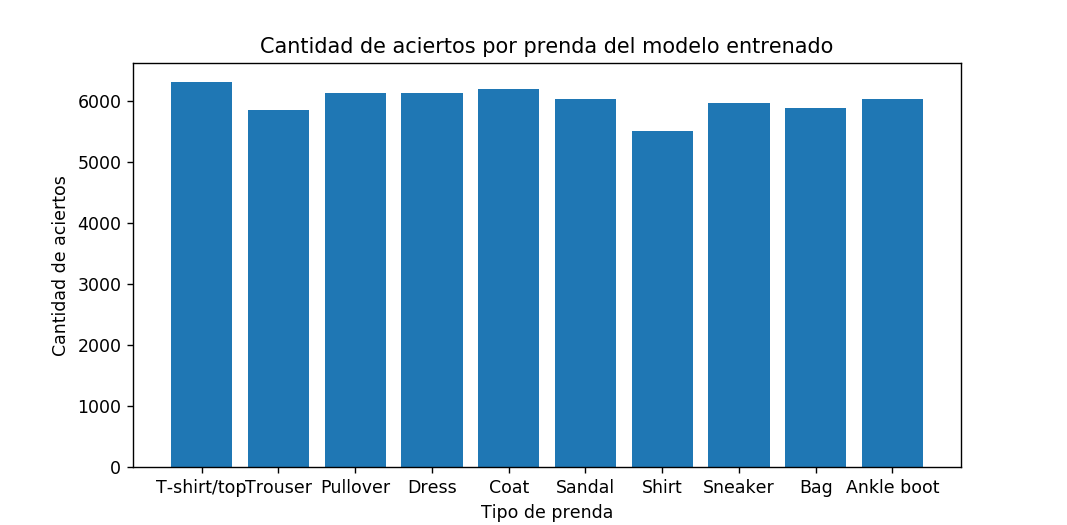

[]

In [49]:
%matplotlib notebook
plt.bar(range(len(correct_dict)), list(correct_dict.values()), align='center')
plt.xticks(range(len(correct_dict)), list(labels))
plt.title("Cantidad de aciertos por prenda del modelo entrenado")
plt.xlabel("Tipo de prenda")
plt.ylabel("Cantidad de aciertos")
plt.plot()

Podemos observar que el tipo de prenda con menos aciertos fue _shirt_ , con un total aproximado de 5500 aciertos; mientras que el tipo de prenda con mayor cantidad de aciertos fue _T-shirt/top_. Ahora por otra parte, vamos a visualizar la cantidad de respuestas incorrectas según el tipo de prenda.

<IPython.core.display.Javascript object>


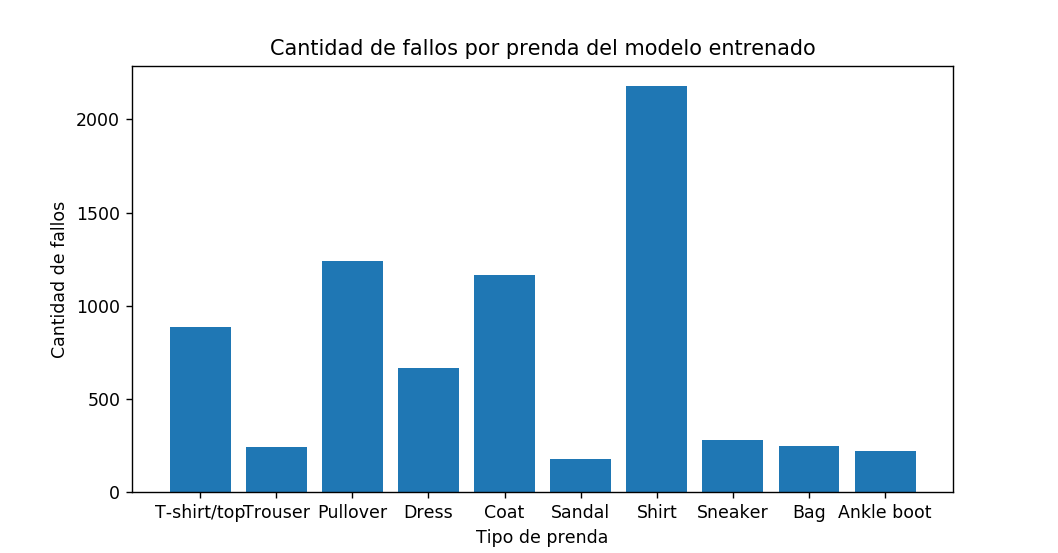

[]

In [106]:
plt.bar(range(len(incorrect_dict)), list(incorrect_dict.values()), align='center')
plt.xticks(range(len(incorrect_dict)), list(labels))
plt.title("Cantidad de fallos por prenda del modelo entrenado")
plt.xlabel("Tipo de prenda")
plt.ylabel("Cantidad de fallos")
plt.plot()

Como era de esperar, el tipo de prenda que menos acertó el modelo fue _Shirt_ , seguido del _Pullover_. No obstante, el rendimiento del modelo se ve bastante óptimo y se podría hacer la hipótesis que falló más en el tipo de prenda _shirt_ dado que es muy parecido a una T-shirt o un top. 

A continuación, se graficara unos cuantos modelos acertas e inacertados por parte del modelo.

Valor predecido: Pullover
Valor real: Pullover


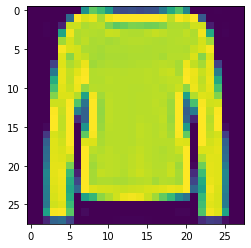

Valor predecido: Trouser
Valor real: Trouser


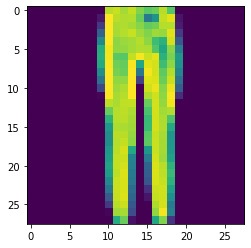

Valor predecido: Coat
Valor real: Coat


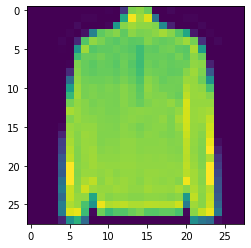

Valor predecido: Ankle boot
Valor real: Ankle boot


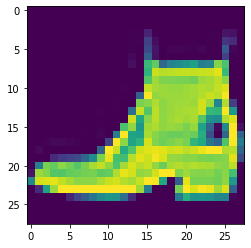

Valor predecido: Shirt
Valor real: Shirt


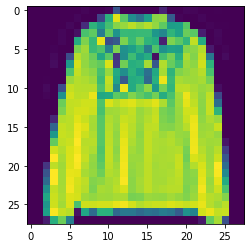

Valor predecido: Coat
Valor real: Coat


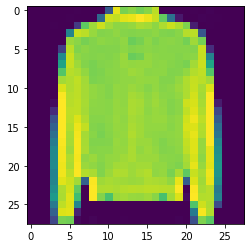

Valor predecido: Trouser
Valor real: Trouser


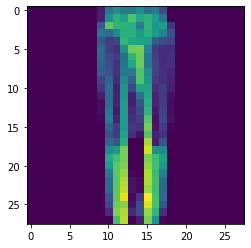

Valor predecido: Ankle boot
Valor real: Ankle boot


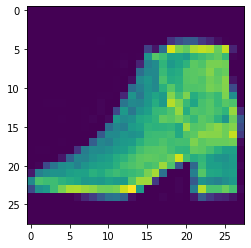

Valor predecido: Coat
Valor real: Pullover


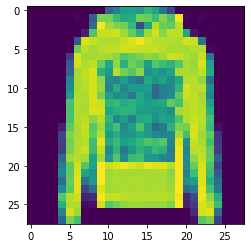

Valor predecido: T-shirt/top
Valor real: T-shirt/top


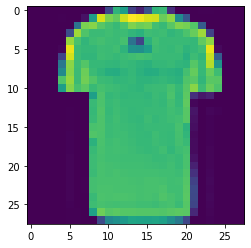

Valor predecido: Ankle boot
Valor real: Ankle boot


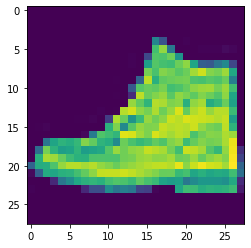

Valor predecido: Trouser
Valor real: Trouser


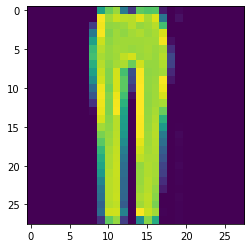

Valor predecido: Coat
Valor real: Pullover


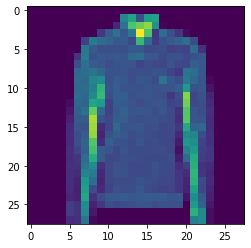

Valor predecido: Shirt
Valor real: Shirt


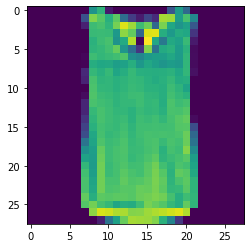

Valor predecido: Bag
Valor real: Bag


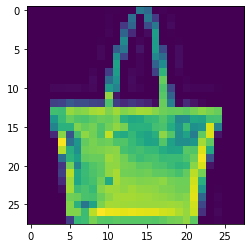

Valor predecido: Sneaker
Valor real: Sneaker


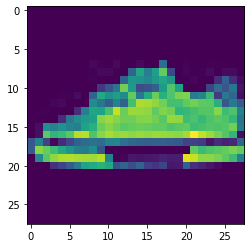

Valor predecido: Dress
Valor real: Dress


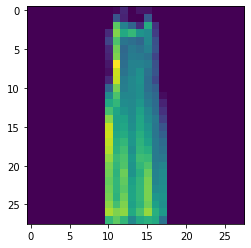

Valor predecido: Trouser
Valor real: Trouser


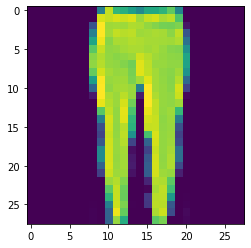

Valor predecido: Sandal
Valor real: Sandal


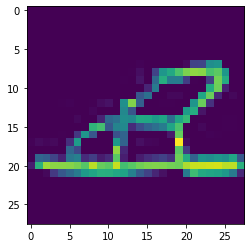

Valor predecido: Dress
Valor real: Dress


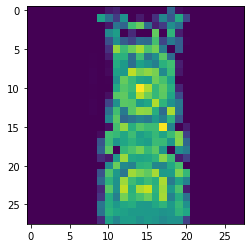

In [112]:
%matplotlib inline
for i in range(20):
    _random = random.randint(0,60000)
    pixeles = np.asarray(test_data[_random]*1000)
    array = np.array(pixeles, dtype=np.uint8)
    array = array.reshape(28,28)
    image = Image.fromarray(array)
    
    print("Valor predecido:", labels[pred_results[_random][0]])
    print("Valor real:", labels[pred_results[_random][1]])
    
    plt.imshow(image)
    plt.show()
    

## Conclusiones:



* El modelo entrenado posee, en promedio, un 86% de aciertos al identificar prendas de ropa.
* La optimización de la red neuronal fue considerablemente eficiente dado un set de datos inicial.
* La arquitectura con una sola capa oculta es un buen factor para entrenar un modelo.
* El principal factor de error es que es difícil diferenciar entre una shirt y una T-shirt